In [1]:
import numpy as np
import pandas as pd
from scipy.fft import fft, ifft
import cmath

from processing_func import from_S_to_T, from_T_to_S
from file_opener import run

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt

In [3]:
###de_embadding = False # указать, нужен или не нужен
time_gating = True # указать, нужен или не нужен

### Импорт сырых данных из .s2p файла и перевод их в комплексные числа

In [4]:
data_object = pd.read_csv('sample.s2p', sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS11', 'ImS11', 'ReS21', 'ImS21', 'ReS12', 'ImS12', 'ReS22', 'ImS22'])

data_screen = pd.read_csv('screen.s2p', sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS11', 'ImS11', 'ReS21', 'ImS21', 'ReS12', 'ImS12', 'ReS22', 'ImS22'])

data_free = pd.read_csv('free.s2p', sep=' ', header=None, skiprows=5, skipinitialspace=True, index_col=False,
                names=['Frequency', 'ReS11', 'ImS11', 'ReS21', 'ImS21', 'ReS12', 'ImS12', 'ReS22', 'ImS22'])

In [5]:
data_object.head() # Смотрим корректность импорта данных

,Frequency,ReS11,ImS11,ReS21,ImS21,ReS12,ImS12,ReS22,ImS22
0,2.000000e+10,-0.206694,-0.148327,-0.000116,0.000151,0.000043,-0.000634,0.834244,-1.621693
1,2.000125e+10,-0.193763,-0.143851,-0.000102,-0.000009,-0.000892,0.000466,0.958220,-1.538202
2,2.000250e+10,-0.179724,-0.138834,-0.000097,0.000111,-0.000227,0.000073,1.080611,-1.499617
3,2.000375e+10,-0.165740,-0.134070,-0.000074,0.000171,-0.000257,-0.000309,1.166713,-1.444760
4,2.000500e+10,-0.152007,-0.127605,-0.000091,0.000156,-0.000578,0.000593,1.245064,-1.338571


Перевод данных в вид комплексных чисел

In [6]:
for dataset in [data_object, data_screen, data_free]: # это массив из указателей на соответствующие
    dataset['s11']=dataset['ReS11']+1j*dataset['ImS11']
    dataset['s21']=dataset['ReS21']+1j*dataset['ImS21']
    dataset['s12']=dataset['ReS12']+1j*dataset['ImS12']
    dataset['s22']=dataset['ReS22']+1j*dataset['ImS22']

Удаление исходных колонок

In [7]:
data_object = data_object.drop(['ReS11', 'ImS11', 'ReS21', 'ImS21', 'ReS12', 'ImS12', 'ReS22', 'ImS22'], axis=1)
data_screen = data_screen.drop(['ReS11', 'ImS11', 'ReS21', 'ImS21', 'ReS12', 'ImS12', 'ReS22', 'ImS22'], axis=1)
data_free = data_free.drop(['ReS11', 'ImS11', 'ReS21', 'ImS21', 'ReS12', 'ImS12', 'ReS22', 'ImS22'], axis=1)

In [8]:
data_object.head() # просмотр нового датасета

,Frequency,s11,s21,s12,s22
0,2.000000e+10,-0.206694-0.148327j,-0.000116+0.000151j,0.000043-0.000634j,0.834244-1.621693j
1,2.000125e+10,-0.193763-0.143851j,-0.000102-0.000009j,-0.000892+0.000466j,0.958220-1.538202j
2,2.000250e+10,-0.179724-0.138834j,-0.000097+0.000111j,-0.000227+0.000073j,1.080611-1.499617j
3,2.000375e+10,-0.165740-0.134070j,-0.000074+0.000171j,-0.000257-0.000309j,1.166713-1.444760j
4,2.000500e+10,-0.152007-0.127605j,-0.000091+0.000156j,-0.000578+0.000593j,1.245064-1.338571j


Создаем переменные, с которыми будем непосредственно работать (массивы формата `pd.Series`)

In [9]:
frequency = data_object['Frequency']

s11_object = data_object['s11']
s21_object = data_object['s21']

s11_screen = data_screen['s11']
s21_screen = data_screen['s21']

s11_free = data_free['s11']
s21_free = data_free['s21']

### Предпросмотр графиков необработанных файлов

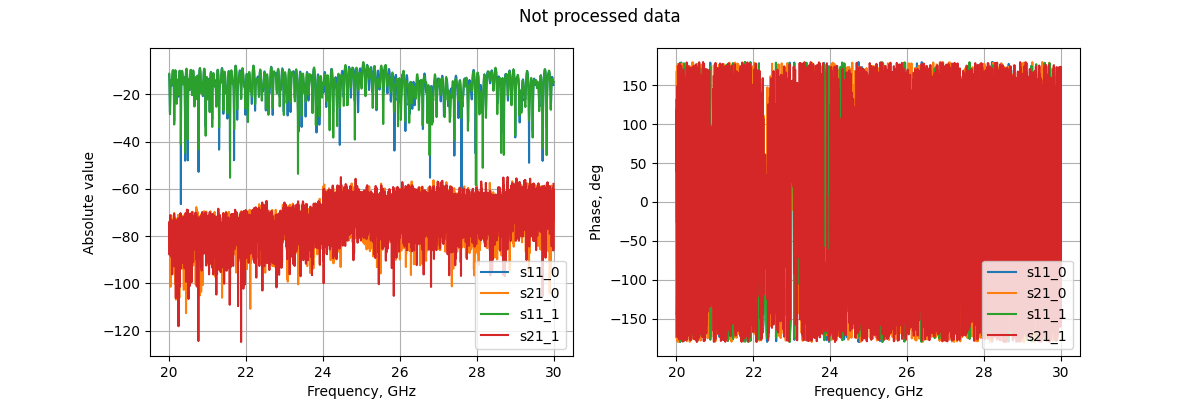

In [10]:
s_par = ['s11', 's21'] # Вести сюда названия S-параметров, которые нужны на графике в формате 'sij'
data = [data_object, data_screen] # Ввести сюда какие измерения нужны


'''Дальше  не трогать!!!'''
fig = plt.figure(figsize=(12,4))

ax_1 = fig.add_subplot(121)
ax_2 = fig.add_subplot(122)
for i, dataset in enumerate(data):
    for elem in s_par:
        ax_1.plot(dataset['Frequency']*1e-9, 20*np.log10(dataset[elem].apply(abs).to_numpy()), label=elem+'_'+str(i))
        ax_2.plot(dataset['Frequency']*1e-9, np.degrees(dataset[elem].apply(cmath.phase)), label=elem+'_'+str(i))

ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()

ax_2.set_xlabel("Frequency, GHz")
ax_2.set_ylabel("Phase, deg")
ax_2.legend()
ax_2.grid()


fig.suptitle('Not processed data')
#plt.tight_layout()
plt.show()

### Time-Gating

In [11]:
N_fft = 2 ** 22 # количиство точек во временной области
# Должно иметь степень двойки для большей скорости и быть большем, чем количество частотных точек
T_max = 1 / (frequency[1]-frequency[0]) # продолжительность измеряемого импульса, определяется из количества измеряемых частотных точек
print(T_max)

8e-07


In [12]:
time = T_max*np.linspace(0, 1 + T_max, N_fft) # набор точек во временной области
time[-1] # последний элемент

8.0000064e-07

Просмотр S-параметров во временной области

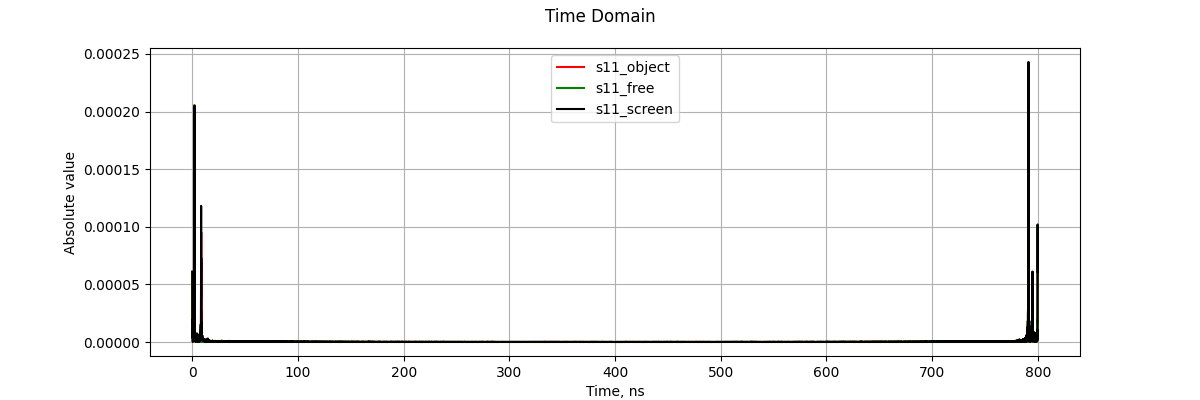

In [13]:
# param = s11_object
# name = 's11_object'

fig2 = plt.figure(figsize=(12,4))

ax_1 = fig2.add_subplot(111)
ax_1.plot(time*1e9, abs(ifft(s11_object.to_numpy(), n=N_fft)),'r', label='s11_object')
ax_1.plot(time*1e9, abs(ifft(s11_free.to_numpy(), n=N_fft)),'g', label='s11_free')
ax_1.plot(time*1e9, abs(ifft(s11_screen.to_numpy(), n=N_fft)),'k', label='s11_screen')

ax_1.set_xlabel("Time, ns")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()


fig2.suptitle('Time Domain')
plt.show()

In [14]:
gate_s11_object = np.array([[0, 7], [10, 900]])*1e-9 # заполнить промежутками времени, которые необходимо вырезать в нс
gate_s21_object = np.array([[], []])*1e-9

gate_s11_screen = np.array([[0,7], [10, 900]])*1e-9 
gate_s21_screen = np.array([[], []])*1e-9

gate_s11_free = np.array([[0, 7], [10, 900]])*1e-9 
gate_s21_free = np.array([[], []])*1e-9

In [15]:
def time_gate_s_param(gate: np.ndarray, s_par: pd.core.series.Series, n=N_fft, time=time):
    s = s_par.to_numpy()
    time_dom_s = pd.Series(ifft(s, n=n))
    for k in range(gate.shape[0]):
        if len(gate[k, :]) != 0:
            numbers = (time >= gate[k, 0]) & (time <= gate[k, 1])
            time_dom_s.loc[numbers] = 0
            #print(time_dom_s.head())
    s_new = fft(time_dom_s.to_numpy())
    s_new = s_new[0:len(frequency)]
    return pd.Series(s_new)

Проведение тайм-гейтинга

In [16]:
if time_gating == True:
    s11_object = time_gate_s_param(gate=gate_s11_object, s_par=s11_object)
    s21_object = time_gate_s_param(gate=gate_s21_object, s_par=s21_object)
    s11_screen = time_gate_s_param(gate=gate_s11_screen, s_par=s11_screen)
    s21_screen = time_gate_s_param(gate=gate_s21_screen, s_par=s21_screen)
    s11_free = time_gate_s_param(gate=gate_s11_free, s_par=s11_free)
    s21_free = time_gate_s_param(gate=gate_s21_free, s_par=s21_free)

In [17]:
s11_object.shape # проверка, что число точек осталось таким же, как в исходных данных

(8001,)

Просмотр S-параметров после тайм-гейтинга

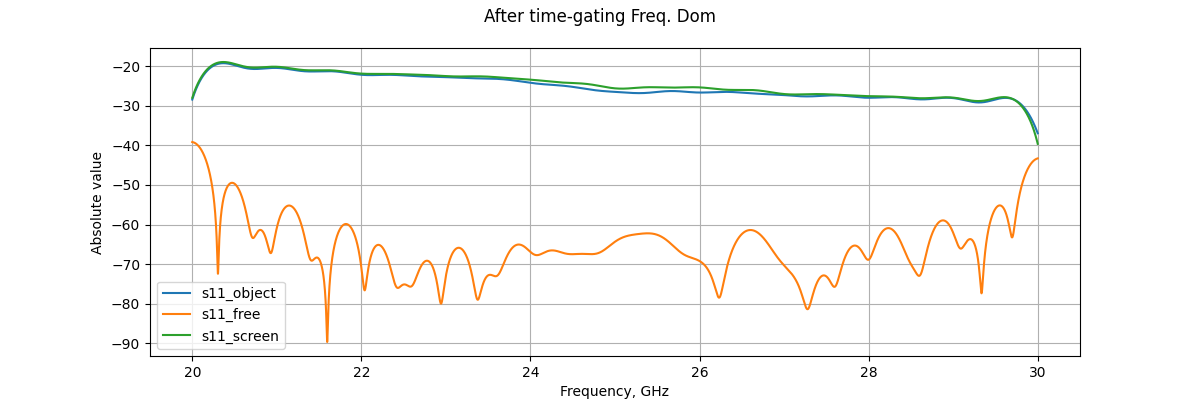

In [18]:
param = [s11_object, s11_free, s11_screen]
name = ['s11_object', 's11_free', 's11_screen']

fig3 = plt.figure(figsize=(12,4))

ax_1 = fig3.add_subplot(111)

for i, s_par in enumerate(param):
    ax_1.plot(frequency*1e-9, 20*np.log10(s_par.apply(abs).to_numpy()), label=name[i])
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()


fig3.suptitle('After time-gating Freq. Dom')
plt.show()

### Итоговые выражения для коэффициента отражения

In [19]:
Gamma = -(s11_object - s11_free) / (s11_screen - s11_free)

### Импорт графиков из CST

In [20]:
reflecting_coef_30deg_TE = pd.read_csv('ND_struct_0deg_s11_TE.txt', sep='\t', header=None, skiprows=3, 
                names=['Frequency', 'ReSz11', 'ImSz11'])

In [21]:
#reflecting_coef_30deg_TE['Frequency'] = 1e9*reflecting_coef_30deg_TE['Frequency']
reflecting_coef_30deg_TE['Sz11'] = reflecting_coef_30deg_TE['ReSz11'] + 1j*reflecting_coef_30deg_TE['ImSz11']

In [22]:
reflecting_coef_30deg_TE = reflecting_coef_30deg_TE.drop(['ReSz11', 'ImSz11'], axis=1)

In [23]:
reflecting_coef_30deg_TE.head()

,Frequency,Sz11
0,20.00,-0.781365+0.619350j
1,20.01,-0.780787+0.620059j
2,20.02,-0.780207+0.620770j
3,20.03,-0.779624+0.621482j
4,20.04,-0.779039+0.622196j


In [24]:
cst_freq = reflecting_coef_30deg_TE['Frequency']
cst_Gamma = reflecting_coef_30deg_TE['Sz11']

### Сравенние графиков с результатами CST

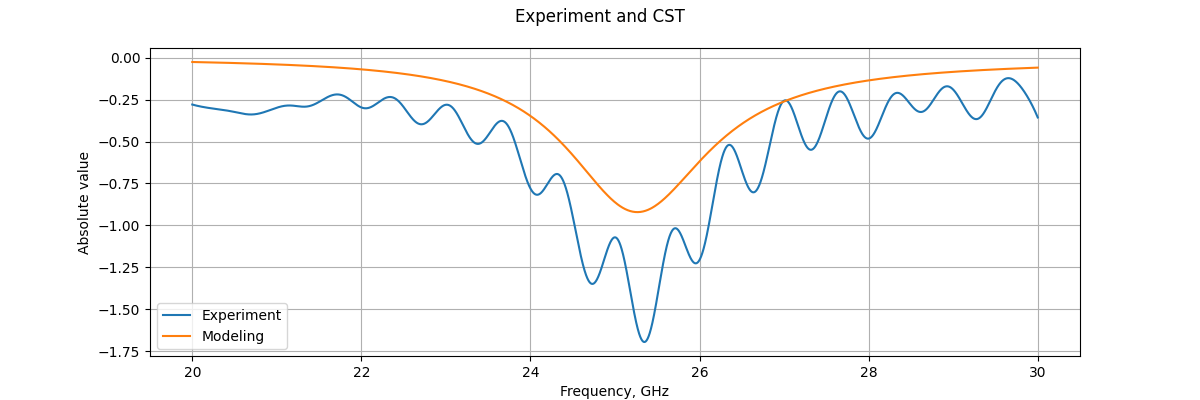

In [25]:
fig4 = plt.figure(figsize=(12,4))

ax_1 = fig4.add_subplot(111)

ax_1.plot(frequency*1e-9, 20*np.log10(Gamma.apply(abs).to_numpy()), label='Experiment')
ax_1.plot(cst_freq, 20*np.log10(cst_Gamma.apply(abs).to_numpy()), label='Modeling')
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Absolute value")
ax_1.legend()
ax_1.grid()


fig4.suptitle('Experiment and CST')
plt.show()

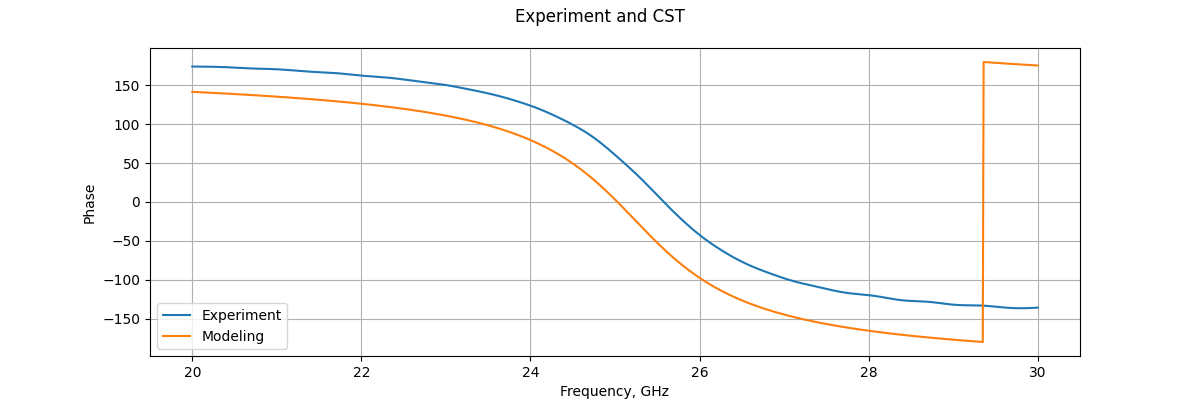

In [26]:
fig4 = plt.figure(figsize=(12,4))

ax_1 = fig4.add_subplot(111)

ax_1.plot(frequency*1e-9, np.degrees(pd.Series(Gamma).apply(cmath.phase).to_numpy()), label='Experiment')
ax_1.plot(cst_freq, np.degrees(cst_Gamma.apply(cmath.phase).to_numpy()), label='Modeling')
ax_1.set_xlabel("Frequency, GHz")
ax_1.set_ylabel("Phase")
ax_1.legend()
ax_1.grid()


fig4.suptitle('Experiment and CST')
plt.show()